Import libraries

In [9]:
%matplotlib ipympl

import numpy as np
import numpy.lib.stride_tricks as st
import matplotlib.pyplot as plt
import hj_reachability as hj
import hj_reachability.shapes as shp
import pyspect as ps
import plotly.graph_objects as go
import skimage.io as sio

from IPython.display import Image
from ipywidgets import interact, IntSlider
from functools import partial, wraps

import numpy as np
import matplotlib.pyplot as plt

import numba as nb
from scipy.signal import correlate2d

Define grid parameters

dx = 0.099999994 dy = 0.099999994 da = 0.20268339 dv = 0.1


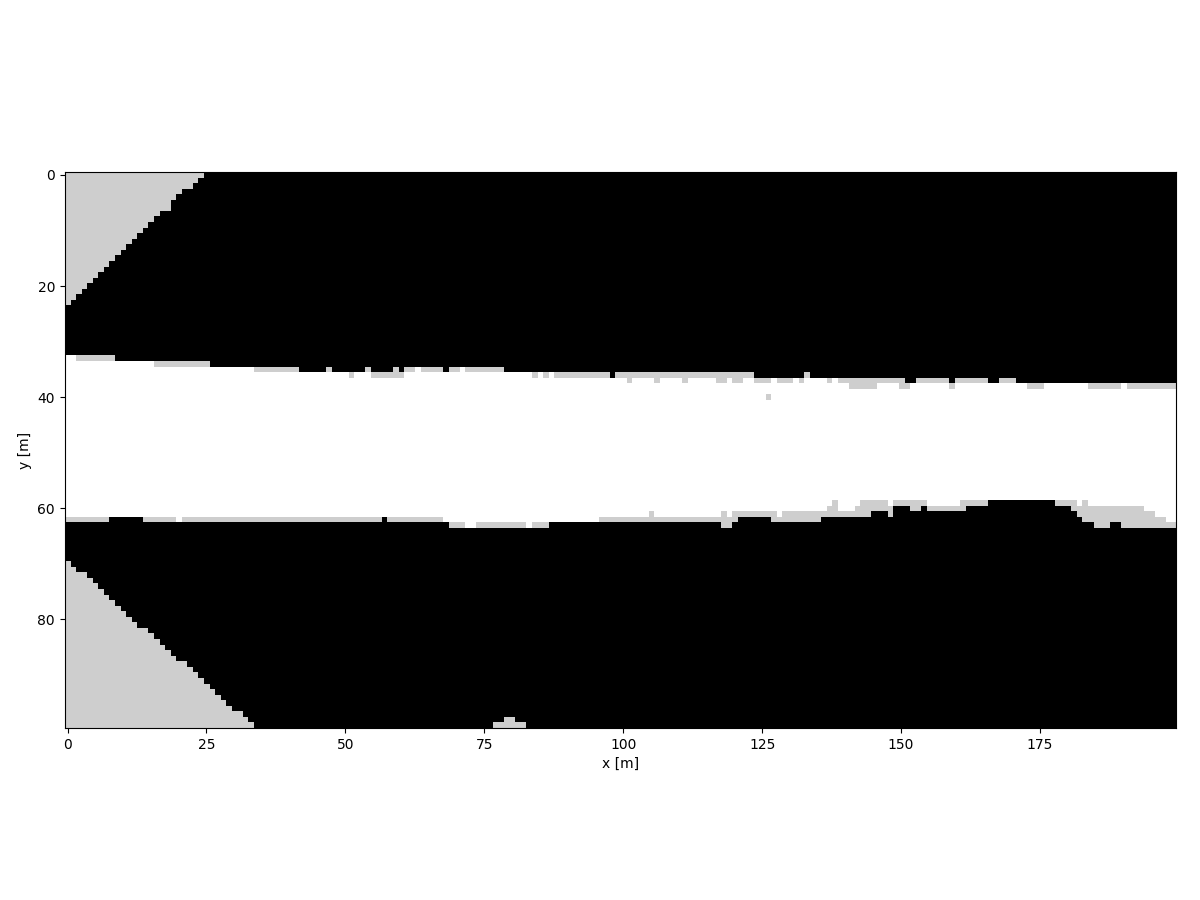

In [10]:
BACKGROUND_PATH = 'sidewalk_map.png'

reach_dynamics = hj.systems.Bicycle5D(min_steer=-5*np.pi/4, 
                                      max_steer=+5*np.pi/4,
                                      min_accel=-0.4,
                                      max_accel=+0.4).with_mode('reach')

min_bounds = np.array([0.0, -2.5, -np.pi, -np.pi/5, +0.1])
max_bounds = np.array([10.0, 2.5, +np.pi, +np.pi/5, +1.1])
grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(hj.sets.Box(min_bounds, max_bounds),
                                                               (101, 51, 31, 7, 11),
                                                               periodic_dims=2)

X, Y, A, D, V = range(grid.ndim)

print('dx =', grid.spacings[0], 
      'dy =', grid.spacings[1],
      'da =', grid.spacings[2],
      'dv =', grid.spacings[4])

plt.imshow(sio.imread(BACKGROUND_PATH), cmap='gray')
plt.show()

Vizualiation helper functions

In [11]:
def auto_ax(f):
    @wraps(f)
    def wrapper(*args, ax: plt.Axes = None, **kwargs):
        if ax is None:
            _, ax = plt.subplots()
        kwargs.update(ax=ax)
        return f(*args, **kwargs)
    return wrapper

@auto_ax
def plot_im(im, *, ax, transpose=True, **kwargs):
    # im = np.where(im, 0.5, np.nan)
    if transpose:
        im = np.transpose(im)
    kwargs.setdefault('cmap', 'Blues')
    kwargs.setdefault('aspect', 'auto')
    return [ax.imshow(im, vmin=0, vmax=1, origin='lower', **kwargs)]

@auto_ax
def plot_set(vf, **kwargs):
    kwargs.setdefault('aspect', 'equal')
    # return plot_im(vf <= 0, **kwargs)
    return plot_im(vf, **kwargs)

@auto_ax
def plot_set_many(*pairs, **kwargs):
    out = []
    f = lambda x: x if isinstance(x, tuple) else (x, {})
    for vf, kw in map(f, pairs):
        out += plot_set(vf, **kw, **kwargs)
    return out

def new_map(*pairs, **kwargs):
    fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(9*4/3, 9))
    extent=[min_bounds[0], max_bounds[0],
            min_bounds[1], max_bounds[1]]
    ax.set_ylabel("y [m]")
    ax.set_xlabel("x [m]")
    ax.invert_yaxis()
    background = plt.imread(BACKGROUND_PATH)
    ax.imshow(background, extent=extent, cmap='gray')
    plot_set_many(*pairs, ax=ax, alpha=0.9, extent=extent, **kwargs)
    fig.tight_layout()
    return fig

In [12]:
def new_timeline(target_time, start_time=0, time_step=0.2):
    assert time_step > 0
    is_forward = target_time >= start_time
    target_time += 1e-5 if is_forward else -1e-5
    time_step *= 1 if is_forward else -1
    return np.arange(start_time, target_time, time_step)

def interact_scenario(times, *pairs):
    fig, ax = plt.figure(), plt.gca()
    extent=[min_bounds[0], max_bounds[0],
            min_bounds[1], max_bounds[1]]
    ax.set_xlabel("x [m]")
    ax.set_ylabel("y [m]")
    ax.axis('off')
    ax.invert_yaxis()
    interaction = partial(interact, 
                        #   yaw_idx=IntSlider(0, min=0, max=grid.shape[2]-1),
                          vel_idx=IntSlider(0, min=0, max=grid.shape[4]-1),
                          time_idx=IntSlider(0, min=0, max=len(times)-1))
    def render_frame(# yaw_idx, 
                     vel_idx, 
                     time_idx):
        # print('yaw:', grid.coordinate_vectors[2][yaw_idx] * 180/np.pi)
        print('vel:', grid.coordinate_vectors[4][vel_idx])
        print('t:', times[time_idx])
        ax.clear()
        background = plt.imread(BACKGROUND_PATH)
        ax.imshow(background, extent=extent, cmap='gray')
        for cmap, vf in pairs:
            cmap = plt.get_cmap(cmap)
            if not shp.is_invariant(grid, times, vf):
                vf = vf[time_idx, :, :, :, :, vel_idx]
            vf = shp.project_onto(vf, 0, 1)
            plot_set(vf, ax=ax, alpha=0.9, cmap=cmap, extent=extent)
            # ix, iy = np.unravel_index(vf.argmin(), vf.shape)
            # x = grid.coordinate_vectors[0][ix]
            # y = grid.coordinate_vectors[1][iy]
            # a = grid.coordinate_vectors[2][yaw_idx]
            # if vf[ix, iy] <= 0:
            #     plot_arrow(ax, (x, y), a, color=cmap(0.75))
        fig.tight_layout()
        return fig
    return interaction, render_frame

def interact_tubes_time(times, *triplets, eye=None):
    background = sio.imread(BACKGROUND_PATH, as_gray=True)
    background = np.flipud(background)

    interaction = partial(interact, time_idx=IntSlider(len(times)-1, min=0, max=len(times)-1))
    def render_frame(time_idx=None):
        data = []

        meshgrid = np.mgrid[times[0]:times[-1]:complex(0, len(times)),
                            min_bounds[0]:max_bounds[0]:complex(0, grid.shape[0]), 
                            min_bounds[1]:max_bounds[1]:complex(0, grid.shape[1])]
        
        data += [
            go.Surface(
                x=np.linspace(min_bounds[0], max_bounds[0], background.shape[1]),
                y=np.linspace(min_bounds[1], max_bounds[1], background.shape[0]),
                z=times[0]*np.ones_like(background)-0.1,
                surfacecolor=background,
                colorscale='gray', 
                showscale=False,
            ),
        ]

        for triplet in triplets:

            colorscale, values = triplet[:2]
            kwargs = triplet[2] if len(triplet) == 3 else {}

            vf = shp.project_onto(values, 0, 1, 2)
            if time_idx is not None and time_idx < len(times)-1:
                vf[time_idx+1:] = 1

            data += [
                go.Isosurface(
                    x=meshgrid[1].flatten(),
                    y=meshgrid[2].flatten(),
                    z=meshgrid[0].flatten(),
                    value=vf.flatten(),
                    colorscale=colorscale,
                    showscale=False,
                    isomin=0,
                    surface_count=1,
                    isomax=0,
                    caps=dict(x_show=True, y_show=True),
                    **kwargs,
                ),
            ]
        
        fw = go.FigureWidget(data=data)
        fw.layout.update(width=720, height=720, 
                         margin=dict(l=10, r=10, t=10, b=10),
                        #  legend=dict(yanchor='bottom', xanchor='left', x=0.05, y=0.05, font=dict(size=16)),
                         scene=dict(xaxis_title='x [m]',
                                    yaxis_title='y [m]',
                                    zaxis_title='t [s]',
                                    aspectratio=dict(x=1, y=3/4, z=3/4)),
                         scene_camera=dict(eye=eye))
        fw._config = dict(toImageButtonOptions=dict(height=720, width=720, scale=6))
        return fw
    return interaction, render_frame

def interact_tubes_axis(times, *triplets, axis=2, eye=None):
    background = sio.imread(BACKGROUND_PATH, as_gray=True)
    background = np.flipud(background)

    interaction = partial(interact, time_idx=IntSlider(len(times)-1, min=0, max=len(times)-1))
    def render_frame(time_idx=None):
        data = []

        meshgrid = np.mgrid[min_bounds[0]:max_bounds[0]:complex(0, grid.shape[0]), 
                            min_bounds[1]:max_bounds[1]:complex(0, grid.shape[1]),
                            min_bounds[axis]:max_bounds[axis]:complex(0, grid.shape[axis])]
        
        data += [
            go.Surface(
                x=np.linspace(min_bounds[0], max_bounds[0], background.shape[1]),
                y=np.linspace(min_bounds[1], max_bounds[1], background.shape[0]),
                z=min_bounds[axis]*np.ones_like(background)-0.1,
                surfacecolor=background,
                colorscale='gray', 
                showscale=False,
            ),
        ]

        for triplet in triplets:

            colorscale, values = triplet[:2]
            kwargs = triplet[2] if len(triplet) == 3 else {}

            axes = 1, 2, axis+1
            vf = (shp.project_onto(values, *axes) if time_idx is None else
                  shp.project_onto(values, 0, *axes)[time_idx])

            data += [
                go.Isosurface(
                    x=meshgrid[0].flatten(),
                    y=meshgrid[1].flatten(),
                    z=meshgrid[2].flatten(),
                    value=vf.flatten(),
                    colorscale=colorscale,
                    showscale=False,
                    isomin=0,
                    surface_count=1,
                    isomax=0,
                    caps=dict(x_show=True, y_show=True),
                    **kwargs,
                ),
            ]
        
        fw = go.FigureWidget(data=data)
        fw.layout.update(width=720, height=720, 
                         margin=dict(l=10, r=10, t=10, b=10),
                        #  legend=dict(yanchor='bottom', xanchor='left', x=0.05, y=0.05, font=dict(size=16)),
                         scene=dict(xaxis_title='x [m]',
                                    yaxis_title='y [m]',
                                    zaxis_title=['Yaw [rad]', 'Delta [rad]', 'Vel [m/s]'][axis-2]),
                         scene_camera=dict(eye=eye))
        fw._config = dict(toImageButtonOptions=dict(height=720, width=720, scale=6))
        return fw
    return interaction, render_frame

def interact_tubes(*args, axis=None, **kwargs):
    return (interact_tubes_time(*args, **kwargs) if axis is None else
            interact_tubes_axis(*args, **kwargs, axis=axis))

def sphere_to_cartesian(r, theta, phi):
    theta *= np.pi/180
    phi *= np.pi/180
    return dict(x=r*np.sin(theta)*np.cos(phi),
                y=r*np.sin(theta)*np.sin(phi),
                z=r*np.cos(theta))

EYE_W   = sphere_to_cartesian(2.2, 45, -90 - 90)
EYE_WSW = sphere_to_cartesian(2.2, 70, -90 - 70)
EYE_SW  = sphere_to_cartesian(2.5, 60, -90 - 45)
EYE_SSW = sphere_to_cartesian(2.2, 70, -90 - 20)
EYE_S   = sphere_to_cartesian(2.5, 45, -90 + 0)
EYE_SSE = sphere_to_cartesian(2.2, 70, -90 + 20)
EYE_SE  = sphere_to_cartesian(2.5, 60, -90 + 45)
EYE_ESE = sphere_to_cartesian(2.2, 70, -90 + 70)
EYE_E   = sphere_to_cartesian(2.2, 45, -90 + 90)

Pyspect implementation

In [13]:
class Set(ps.Set):

    vf: np.ndarray
    grid: hj.Grid
    timeline: np.ndarray
    dynamics: hj.Dynamics

    solver_settings = hj.SolverSettings.with_accuracy("low")
    
    def __init__(self, dynamics, grid, timeline, vf, **kwargs):
        super().__init__(**kwargs)

        self.dynamics = dynamics
        self.timeline = timeline
        self.grid = grid
        self.vf = vf

    def copy(self):
        return Set(self.dynamics, 
                   self.grid, 
                   self.timeline.copy(), 
                   self.vf.copy(), 
                   approx=self.approx)
    
    @classmethod
    def empty(self):
        return np.ones(self.grid.shape)
    
    def is_empty(self):
        return np.all(0 < self.vf)
    
    def membership(self, point):
        idx = self.grid.nearest_index(point)
        return self.vf[idx] <= 0
    
    def complement(self):
        s = super().complement()
        s.vf = np.asarray(-s.vf)
        return s
    
    def union(self, other):
        assert self.grid is other.grid, 'Grids must match'
        assert np.isclose(self.timeline, other.timeline).all(), 'Timelines must match'
        s = super().union(other)
        s.vf = np.asarray(np.minimum(self.vf, other.vf))
        return s
    
    def intersect(self, other):
        assert self.grid is other.grid, 'Grids must match'
        assert np.isclose(self.timeline, other.timeline).all(), 'Timelines must match'
        s = super().intersect(other)
        s.vf = np.asarray(np.maximum(self.vf, other.vf))
        return s
    
    def reach(self, constraints=None):
        s = super().reach(constraints)
        vf = hj.solve(self.solver_settings,
                      self.dynamics,
                      self.grid,
                      -self.timeline,
                      self.vf,
                      constraints if constraints is None else constraints.vf)
        s.vf = np.flip(np.asarray(vf), axis=0)
        return s

    def rci(self):
        s = super().rci()
        s._make_tube()
        target = np.ones_like(s.vf)
        target[-1, ...] = s.vf[-1, ...]
        constraint = s.vf
        vf = hj.solve(self.solver_settings,
                       self.dynamics,
                       self.grid,
                       -self.timeline,
                       target,
                       constraint)
        s.vf = np.asarray(np.flip(vf, axis=0))
        return s

    def _is_invariant(self):
        return len(self.vf.shape) != len(self.timeline.shape + self.grid.shape)

    def _make_tube(self):
        if self._is_invariant():    
            self.vf = np.concatenate([self.vf[np.newaxis, ...]] * len(self.timeline))

def find_windows(mask, N=1, M=None):
    """Find the indices of windows where at least N but less than M consequtive elements are true."""
    mask = np.asarray(mask)
    assert N <= len(mask)
    window_view = st.sliding_window_view(mask, window_shape=N)
    ix, = np.where(N == np.sum(window_view, axis=1))
    if M is not None:
        assert M <= len(mask)
        assert N < M
        window_view = st.sliding_window_view(mask, window_shape=M)
        jx = ix[ix + M <= len(mask)]
        iix, = np.where(np.sum(window_view[jx], axis=1) < M)
        ix = ix[iix]
    return ix

def earliest_window(mask, N=1, M=None):
    """Find the first window where at least N but less than M consequtive elements are true."""
    mask = np.asarray(mask)
    windows = find_windows(mask, N, M)
    if len(windows) == 0:
        return np.array([], int)
    i = windows[0] # Earliest window
    mask = mask[i:] if M is None else mask[i:i+M]
    for j, n in enumerate(mask.cumsum()[N-1:]):
        if n != j + N:
            break
    return np.arange(i, i+n)

def nearest_index(grid, x):
    x = np.array(x)
    # assert (x >= min_bounds).all() and (x <= max_bounds).all(), f'Point {x} is out of bounds'
    ix = np.array(grid.nearest_index(x), int)
    ix = np.where(ix >= grid.shape, np.array(grid.shape)-1, ix)
    return tuple(ix)

def position(grid, ix):
    return np.array([grid.coordinate_vectors[n][ix[n]] for n in range(grid.ndim)])

def spatial_deriv(grid, vf, ix):
    spatial_deriv = []

    for axis in range(len(ix)):
        
        ix_nxt = list(ix)
        ix_nxt[axis] += 1
        ix_nxt = tuple(ix_nxt)

        ix_prv = list(ix)
        ix_prv[axis] -= 1
        ix_prv = tuple(ix_prv)

        sign = np.sign(vf[ix])

        if ix[axis] == 0:
            leftv = (vf[ix_nxt[:axis] + (-1,) + ix_nxt[axis+1:]] if grid._is_periodic_dim[axis] else 
                      vf[ix] + sign*np.abs(vf[ix_nxt] - vf[ix]))
            rightv = vf[ix_nxt]
        elif ix[axis] == grid.shape[axis] - 1:
            leftv = vf[ix_prv]
            rightv = (vf[ix_prv[:axis] + (0,) + ix_prv[axis+1:]] if grid._is_periodic_dim[axis] else 
                      vf[ix] + sign*np.abs(vf[ix] - vf[ix_prv]))
        else:
            leftv = vf[ix_prv]
            rightv = vf[ix_nxt]

        left_dx = (vf[ix] - leftv) / grid.spacings[axis]
        right_dx = (rightv - vf[ix]) / grid.spacings[axis]
        spatial_deriv.append((left_dx + right_dx) / 2)

    return np.array(spatial_deriv)

def walk(dynamics, grid, timeline, vf, x0):

    nx = grid.ndim
    nu = dynamics.control_space.ndim
    nd = dynamics.disturbance_space.ndim
    out = np.zeros((len(timeline), 1 + 1 + nx + nu + nd))

    x = np.array(x0)
    ix = nearest_index(grid, x)
    window = earliest_window(vf[(...,) + ix] <= 0)
    assert window.size > 0, 'Initial state is not inside the level set'
    
    i0 = window[0]
    timeline = timeline[i0:]
    vf = vf[i0:]

    for i, t in enumerate(timeline):
        
        v = vf[(i, *ix)]
        if v > 0:
            break

        dvdx = spatial_deriv(grid, vf[i], ix)
        u, d = dynamics.optimal_control_and_disturbance(x, t, dvdx)
        u, d = map(np.array, (u, d))

        out[i, :] = [t, v, *x, *u, *d]

        if i+1 < len(timeline):
            f = dynamics.open_loop_dynamics(x, t)
            g = dynamics.control_jacobian(x, t)
            w = dynamics.disturbance_jacobian(x, t)
            
            print(i, x, u)
            x += (timeline[i+1] - t) * np.array(f + g @ u + w @ d)
            ix = nearest_index(grid, x)

    return out[:i]

def lrcs(dynamics, grid, dt, vf, x, i):
    # these are invariant wrt t
    f = dynamics.open_loop_dynamics(x, 0)
    g = dynamics.control_jacobian(x, 0)

    ix = nearest_index(grid, x)
    dvdx = spatial_deriv(grid, vf[i], ix)
    
    a = np.array(vf[(i+1, *ix)] + dt*(dvdx.T @ f))
    b = np.array(dt*(dvdx.T @ g))
    return a, b

Evnironment setup

In [14]:
ROBOT_FOOTPRINT = np.array([0.4,0.15,0.15,0.15])

def get_robot_projections(robot_footprint, grid):
    """
    Get the robot projections as a 2D array of (0, 1) values where 1 represents the robot's projection.
    """
    # Assert that the robot footprint is rectangular
    assert len(robot_footprint) == 4, 'Robot footprint must be a rectangle.'
    # Assert that the spacing is the same in both dimensions
    assert grid.spacings[0] == grid.spacings[1], 'Spacing must be the same in both dimensions.'
    spacing = grid.spacings[0]
    theta_values = grid.coordinate_vectors[2]
    num_projections = grid.shape[2]
    # Calculate all corner points of the robot footprint
    corner_points_indices = np.array([[0, 1], [0, 3], [2, 1], [2, 3]])
    corner_points = robot_footprint[corner_points_indices]
    # Calculate the distance from the origin to the corner points
    distances = np.linalg.norm(corner_points, axis=1)
    # Calculate the maximum distance from the origin to the corner points
    max_distance = np.max(distances)
    # Calculate the number of points in the robot projection
    num_points = int(np.ceil(max_distance / spacing))
    # Initialize the robot projection
    robot_projections = np.zeros((2*num_points+1, 2*num_points+1, num_projections))
    # Generate the grid for the robot projection
    min_bounds = np.array([-num_points*spacing, -num_points*spacing])
    max_bounds = np.array([num_points*spacing, num_points*spacing])
    robot_projection_grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(hj.sets.Box(min_bounds, max_bounds), (robot_projections.shape[0], robot_projections.shape[1]))
    # Calculate the robot projection using half-plane surfaces
    for i in range(num_projections):
        theta = theta_values[i]
        robot_projection_front = shp.hyperplane(robot_projection_grid, normal=[np.cos(theta), np.sin(theta)], offset=[robot_footprint[0]*np.cos(theta), robot_footprint[0]*np.sin(theta)])
        robot_projection_left = shp.hyperplane(robot_projection_grid, normal=[np.cos(theta + np.pi/2), np.sin(theta + np.pi/2)], offset=[robot_footprint[1]*np.cos(theta + np.pi/2), robot_footprint[1]*np.sin(theta + np.pi/2)])
        robot_projection_rear = shp.hyperplane(robot_projection_grid, normal=[np.cos(theta + np.pi), np.sin(theta + np.pi)], offset=[robot_footprint[2]*np.cos(theta + np.pi), robot_footprint[2]*np.sin(theta + np.pi)])
        robot_projection_right = shp.hyperplane(robot_projection_grid, normal=[np.cos(theta - np.pi/2), np.sin(theta - np.pi/2)], offset=[robot_footprint[3]*np.cos(theta - np.pi/2), robot_footprint[3]*np.sin(theta - np.pi/2)])
        robot_projection = shp.intersection(robot_projection_front, robot_projection_left, robot_projection_rear, robot_projection_right)
        robot_projections[:, :, i] = np.where(robot_projection <= 0, 1, 0)
        # j = 0
        # print('Robot projection front', robot_projection_front) if i == j else None
        # print('Robot projection left', robot_projection_left) if i == j else None
        # print('Robot projection rear', robot_projection_rear) if i == j else None
        # print('Robot projection right', robot_projection_right) if i == j else None
        # print('Robot projection', robot_projection) if i == j else None
        # print('Robot projections', robot_projections[:, :, i], robot_projection >= 0) if i == j else None
    return robot_projections

def create_filter_array(n, m, l):
    # Define the shape of the array
    shape = (2*n-1, 2*m-1, 2*l-1)
    # Generate a 3D grid of coordinates using np.indices
    x, y, z = np.indices(shape)
    # Calculate the centroid coordinates
    centroid = np.array([n-1, m-1, l-1])
    # Compute the Euclidean distance to the centroid for all points in a vectorized manner
    filter_array = np.sqrt((x - centroid[0])**2 + (y - centroid[1])**2 + (z - centroid[2])**2)
    return filter_array

def create_inflation_set(set, robot_projections):
    """
    Inflate the vf of the set by the robot projection using cross-correlation. The robot footprint is a 2D grid of (0, 1) values where 1 represents the robot's projection on the grid.
    """
    
    # Assert the robot projection is a 3D grid
    assert len(robot_projections.shape) == 3, 'Robot projection must be a 3D grid.'
    
    # Process the input set
    inflated_set = set.copy()
    base_vf = inflated_set.vf[:,:,0,0,0]
    base_vf = np.where(base_vf <= 0, 0, 1)
    print('Base vf shape:', base_vf.shape)
    
    # Inflate the set by the robot projection using cross-correlation
    print('Inflating the set by the robot projection...')
    inflated_grid = np.zeros(inflated_set.vf.shape[:3])
    for i in range(inflated_set.vf.shape[2]):
        robot_projection = robot_projections[:, :, i]
        inflation = correlate2d(base_vf, robot_projection, mode='same', boundary='fill', fillvalue=1)
        inflated_grid[:,:,i] = np.where(inflation > 0, 1, -1)

    # Update the vf of the inflated set by calculating the distance from the nearest boundary
    # print('Inflated grid shape:', inflated_grid.shape)
    # print('Inflated set vf shape:', inflated_set.vf.shape)
    # inflated_set.vf[:,:,:,...] = inflated_grid[...,np.newaxis,np.newaxis]
    
    # inflated_sett = calculate_inflated_vf(inflated_set)
    
    # return inflated_sett  
    
    # Calculate the inflated vf
    inflated_vf = calculate_inflated_vf(inflated_grid)
    inflated_set.vf[:,:,:,...] = inflated_vf[...,np.newaxis,np.newaxis]
    return inflated_set

def calculate_inflated_vf(inflated_grid):
    """
    Calculate the inflated vf using inflated_grid.
    """
    # Create the inflated vf
    inflated_vf = np.zeros(inflated_grid.shape)
    filter = create_filter_array(*inflated_grid.shape)
    filter_center = np.array([filter.shape[0]//2, filter.shape[1]//2, filter.shape[2]//2])
    for i in range(inflated_grid.shape[0]):
        for j in range(inflated_grid.shape[1]):
            for k in range(inflated_grid.shape[2]):
                filter_window = filter[filter_center[0]-i:filter_center[0]+inflated_grid.shape[0]-i, filter_center[1]-j:filter_center[1]+inflated_grid.shape[1]-j, filter_center[2]-k:filter_center[2]+inflated_grid.shape[2]-k]
                inflation_array = filter_window * inflated_grid
                inflation = -np.min(inflation_array[inflation_array > 0]) if inflated_grid[i,j,k] < 0 else -np.max(inflation_array[inflation_array < 0])
                inflated_vf[i,j,k] = inflation
    return inflated_vf

def env(timeline):
    SX, SY = grid.domain.hi[0] - grid.domain.lo[0], grid.domain.hi[1] - grid.domain.lo[1]
    print('SX =', SX, 'SY =', SY)

    # Creating the sidewalk geometries
    print('Creating the sidewalk geometries...')
    sidewalk_down_geometry = Set(reach_dynamics, grid, timeline, shp.hyperplane(grid, normal=[0, 1], offset=[0, 1.15]))
    sidewalk_up_geometry = Set(reach_dynamics, grid, timeline, shp.hyperplane(grid, normal=[0, -1], offset=[0, -1.15]))
    sidewalk = sidewalk_down_geometry.intersect(sidewalk_up_geometry)
    
    # Inflate the sidewalk set by the robot projection
    print('Inflating the sidewalk set by the robot projection...')
    robot_projections = get_robot_projections(ROBOT_FOOTPRINT, grid)
    sidewalk_inflated = create_inflation_set(sidewalk, robot_projections)
    
    # Logging
    print('Environment created.')
    
    return dict(sidewalk=sidewalk, sidewalk_inflated=sidewalk_inflated)

Plot the sidewalk inflation

SX = 10.0 SY = 5.0
Creating the sidewalk geometries...
Inflating the sidewalk set by the robot projection...
Base vf shape: (101, 51)
Inflating the set by the robot projection...
Environment created.


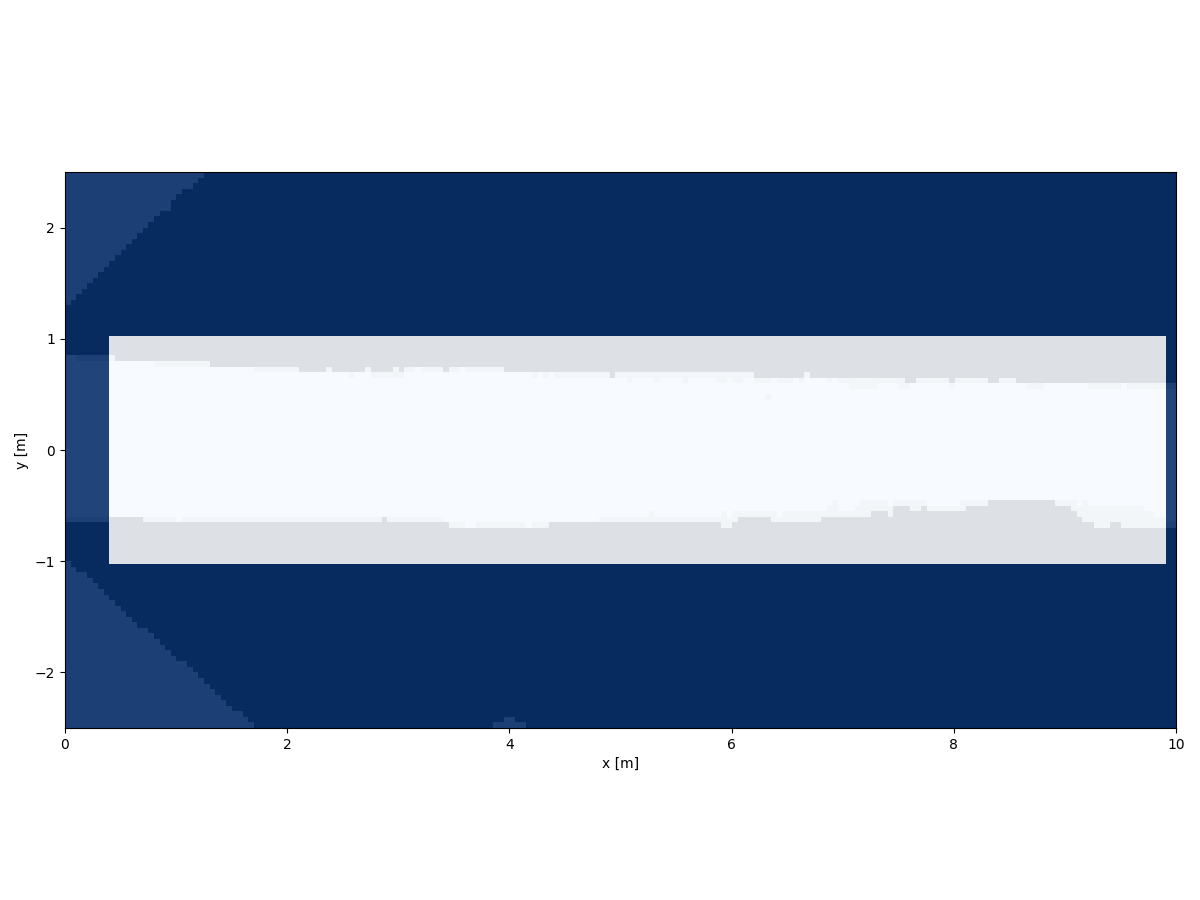

In [15]:
sidewalk_env = env(new_timeline(1.0))
fig = new_map(sidewalk_env['sidewalk_inflated'].vf[:,:,0,0,0], cmap='Blues')

Example: Stay in the sidewalk region

In [16]:
phi = ps.Until('sidewalk', 'sidewalk')
timeline = new_timeline(1.0)
out = phi(**env(timeline))

SX = 10.0 SY = 5.0
Creating the sidewalk geometries...
Inflating the sidewalk set by the robot projection...
Base vf shape: (101, 51)
Inflating the set by the robot projection...
Environment created.


100%|##########|  1.0000/1.0 [01:24<00:00, 84.28s/sim_s] 


Plotting

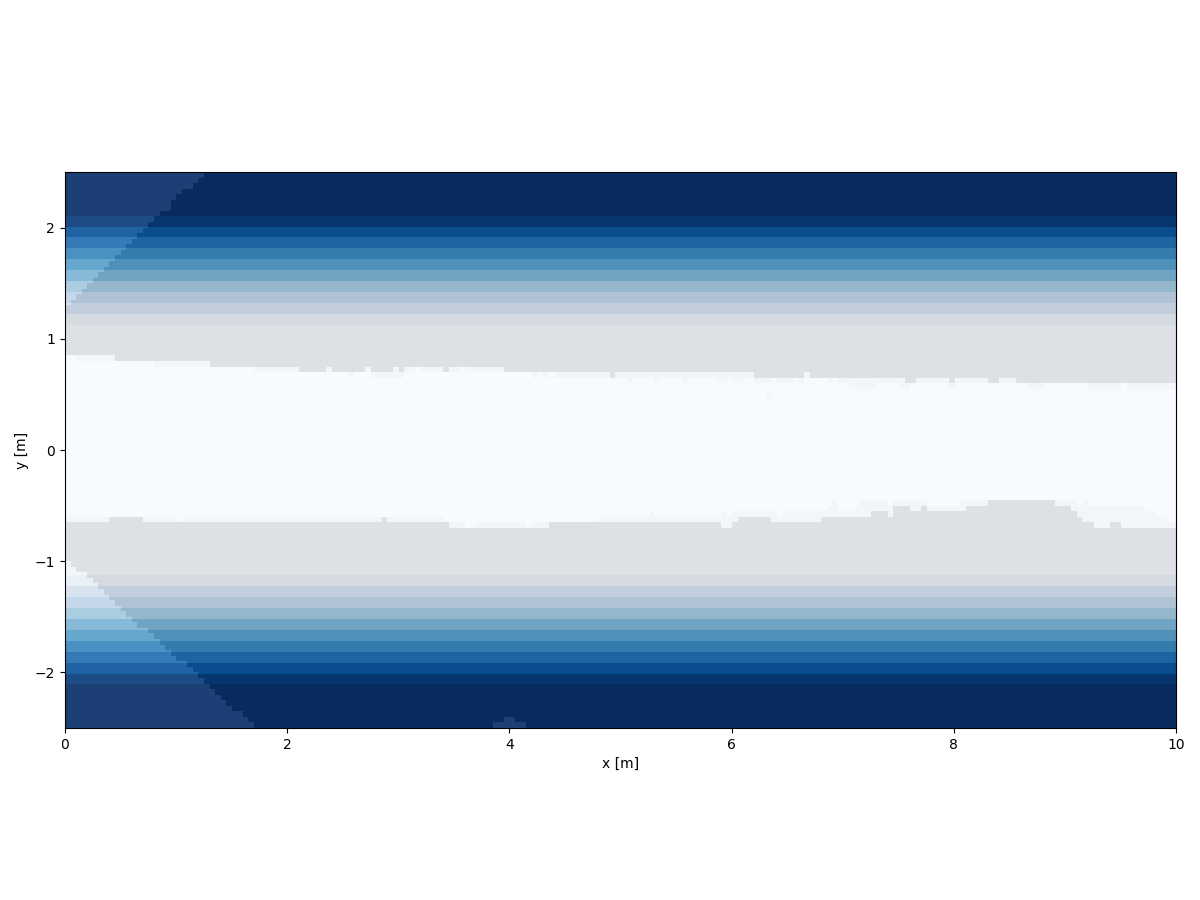

In [17]:
fig = new_map(
    (shp.project_onto(out.vf, 1, 2), dict(cmap='Blues')),
)
# fig.gca().plot(traj[:, 2], traj[:, 3], 'ro')

Example: Stay in the inflated sidewalk region

In [18]:
phi = ps.Until('sidewalk_inflated', 'sidewalk_inflated')
timeline = new_timeline(1.0)
out = phi(**env(timeline))

SX = 10.0 SY = 5.0
Creating the sidewalk geometries...
Inflating the sidewalk set by the robot projection...
Base vf shape: (101, 51)
Inflating the set by the robot projection...
Environment created.


 39%|###9      |  0.3926/1.0 [00:31<00:47, 78.53s/sim_s] 

Plotting

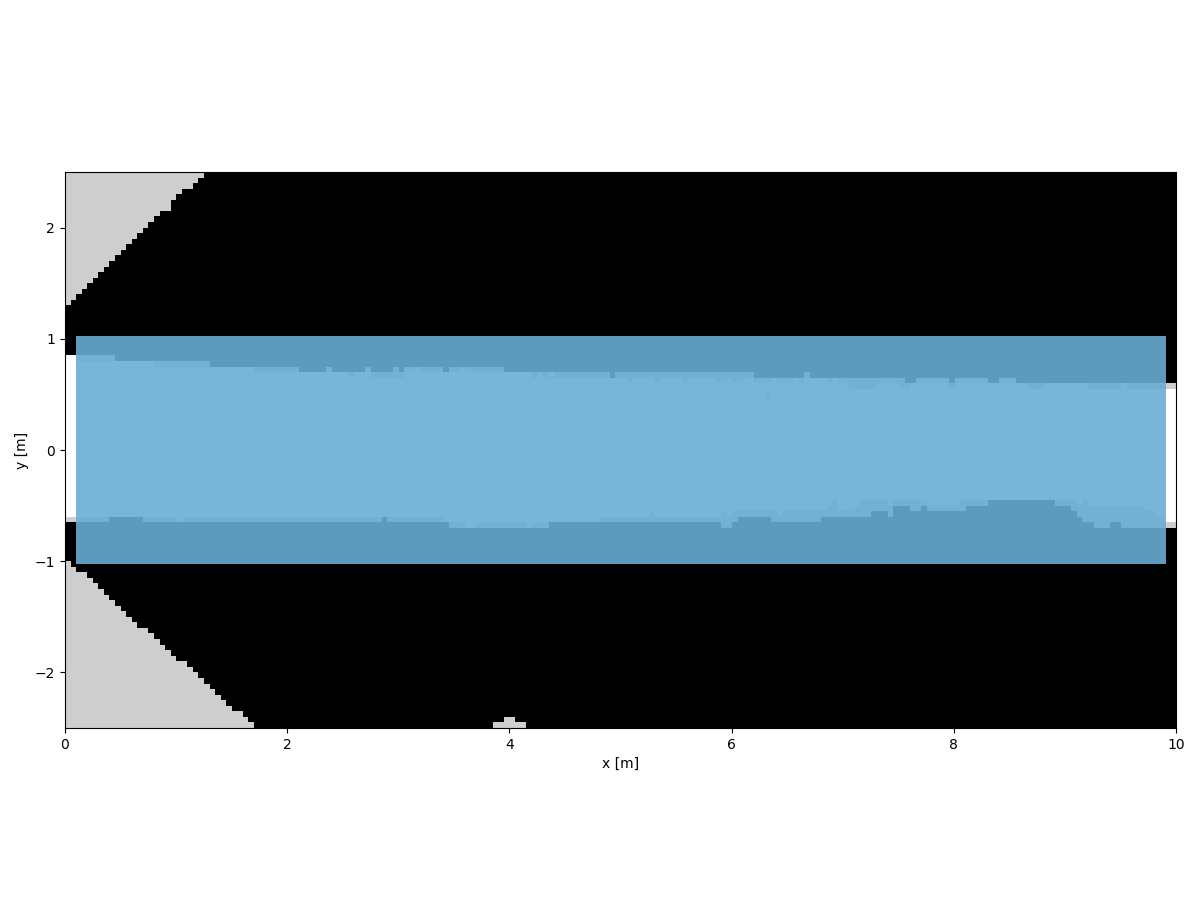

In [ ]:
fig = new_map(
    (shp.project_onto(out.vf, 1, 2), dict(cmap='Blues')),
)
# fig.gca().plot(traj[:, 2], traj[:, 3], 'ro')

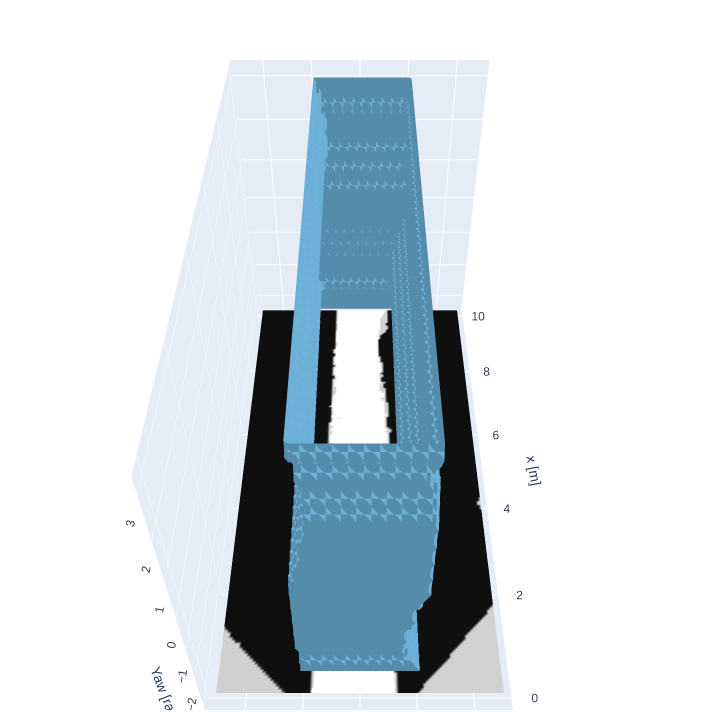

In [ ]:
I, F = interact_tubes(
    timeline,
    ('Blues',   out.vf, dict(opacity=1)),
    eye=EYE_W,
    axis=2,
)
fig = F()
# fig.add_scatter3d(x=traj[:, 2], y=traj[:, 3], z=traj[:, 4], mode='lines+markers', marker=dict(size=3)),
# fig.show(config=dict(toImageButtonOptions=dict(height=720, width=720, scale=6)))
Image(fig.to_image(format='png'))